In [1]:
import sys
sys.path.append('/home/drl/PycharmProjects/underacuatedRoboics/drake/build/install/lib/python2.7/site-packages')

In [27]:
# -*- coding: utf8 -*-
# %%
import numpy as np
import pydrake
import os

from pydrake.common import AddResourceSearchPath, FindResourceOrThrow

from pydrake.multibody.tree import (UniformGravityFieldElement,
                                    WeldJoint, )
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.math import RigidTransform

from pydrake.systems.meshcat_visualizer import MeshcatVisualizer
from pydrake.geometry import SceneGraph
from pydrake.systems.primitives import SignalLogger

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator

from pydrake.systems.primitives import ConstantVectorSource, Sine
from pydrake.geometry import ConnectDrakeVisualizer

from pydrake.systems.controllers import InverseDynamicsController
from pydrake.attic.systems.controllers import RbtInverseDynamicsController
from pydrake.attic.multibody.rigid_body_tree import RigidBodyTree, RigidBodyFrame, FloatingBaseType, \
    AddModelInstanceFromUrdfStringSearchingInRosPackages

motor_name = [
    "FL_hip_joint", "FR_hip_joint", "RR_hip_joint", "RL_hip_joint",
    "FL_thigh_joint", "FR_thigh_joint", "RR_thigh_joint", "RL_thigh_joint",
    "FL_calf_joint", "FR_calf_joint", "RR_calf_joint", "RL_calf_joint",
]

actuator_name = [
    'FL_hip_motor', 'FL_thigh_motor', 'FL_calf_motor',
    'FR_hip_motor', 'FR_thigh_motor', 'FR_calf_motor',
    'RR_hip_motor', 'RR_thigh_motor', 'RR_calf_motor',
    'RL_hip_motor', 'RL_thigh_motor', 'RL_calf_motor']

Leg_list = ['FL', 'FR', 'RR', 'RL']
MAX_TORQUE = 50
actuator_choice_matrix = np.array(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
     [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


def render_system_with_graphviz(system, output_file="system_view.gz"):
    ''' Renders the Drake system (presumably a diagram,
    otherwise this graph will be fairly trivial) using
    graphviz to a specified file. '''
    from graphviz import Source
    string = system.GetGraphvizString()
    src = Source(string)
    src.render(output_file, view=False)


from pydrake.systems.framework import LeafSystem, PortDataType, BasicVector


class RobotStateEncoder(LeafSystem):
    """
    A block system that outputs all state infomation to a lcm publisher.

    Robot Plant --> this block --> lcm Publisher

    Input Port :
        -- joint_state_results_port : kVectorValued  , [n *2 , 1]  the positions and velocties of joints

    Output Port:
        -- lcm_message_port : AbstractValue, lcm publisher type

    """

    def __init__(self):
        LeafSystem.__init__(self)
        # self.rb_tree = rb_tree
        # self.num_position = self.rb_tree.get_num_positions()
        # self.num_controlled_q_ = self.rb_tree.get_num_actuators()
        if is_fixed:
            self.input_num = 24
        else:
            self.input_num = 37
        self.output_num = 24
        self.n = 0

        # Input Port
        self.joint_state_results_port_index = self._DeclareInputPort('joint_state_results_port',
                                                                     PortDataType.kVectorValued,
                                                                     self.input_num).get_index()
        #         self.contact_results_port_index = self._DeclareAbstractInputPort('contact_results_port',
        #                                                                        AbstractValue.Make(ContactResults)).get_index()
        # Output Port

        self.joint_state_outport_index = self._DeclareVectorOutputPort('state_output_port',
                                                                       BasicVector(self.output_num),
                                                                       self._OutputRobotState).get_index()

    def _OutputRobotState(self, context, output):

        states = self.EvalVectorInput(context, self.joint_state_results_port_index).get_value()

        if is_fixed:
            q = states[:12]
            u = states[12:]
        else:
            q = states[7: 19]
            u = states[19 + 6:37]

        # get joint state from full state
        joint_state = np.concatenate((q,
                                      u), axis=0)

        # print(joint_state)

        # self.n = self.n +1
        # if self.n % 100 ==0:
        #     print self.n

        output.SetFromVector(joint_state)

    def joint_state_results_input_port(self):
        return self.get_input_port(self.joint_state_results_port_index)

    def joint_state_outport_port(self):
        return self.get_output_port(self.joint_state_outport_index)


class PDAndFeedForwardController(LeafSystem):
    """
    A block system that outputs all state infomation to a lcm publisher.

    Robot Plant --> this block --> lcm Publisher

    Input Port :
        -- joint_state_results_port : kVectorValued  , [n *2 , 1]  the positions and velocties of joints

    Output Port:
        -- lcm_message_port : AbstractValue, lcm publisher type

    """

    def __init__(self, rb_tree, Kp, Kd):
        LeafSystem.__init__(self)
        self.rb_tree = rb_tree
        self.num_position = self.rb_tree.get_num_positions()
        self.num_controlled_q_ = self.rb_tree.get_num_actuators()

        # self.desired_position = desired_position
        self.input_num = 24
        self.output_num = 12
        self.feedforward_num = 12
        self.n = 0

        self.Kp = Kp
        self.Kd = Kd

        # Input Port
        self.joint_state_results_port_index = self._DeclareInputPort('joint_state_results_port',
                                                                     PortDataType.kVectorValued,
                                                                     self.input_num).get_index()
        #         self.contact_results_port_index = self._DeclareAbstractInputPort('contact_results_port',
        #                                                                        AbstractValue.Make(ContactResults)).get_index()
        self.joint_desired_state_port_index = self._DeclareInputPort('joint_desired_state_port',
                                                                     PortDataType.kVectorValued,
                                                                     self.input_num).get_index()

        self.feedforward_input_port_index = self._DeclareInputPort('feedforward_input_port',
                                                                   PortDataType.kVectorValued,
                                                                   self.feedforward_num).get_index()
        # Output Port

        self.motor_command_outport_index = self._DeclareVectorOutputPort('motor_command_output_port',
                                                                         BasicVector(self.output_num),
                                                                         self._OutputControlCommand).get_index()

    def _OutputControlCommand(self, context, output):
        states = self.EvalVectorInput(context, self.joint_state_results_port_index).get_value()
        desired_states = self.EvalVectorInput(context, self.joint_desired_state_port_index).get_value()
        feedforward = self.EvalVectorInput(context, self.feedforward_input_port_index).get_value()

        q = states[:12]
        v = states[12:]

        q_d = desired_states[:12]
        v_d = desired_states[12:]

        # feedforward  = mbp.CalcInverseDynamics(context, )

        #print(context.get_time())
        #print('q = {}, q_d ={}'.format(q, q_d))
        #print('e= ', q_d - q)
        #print('v = {}, v_d ={}'.format(v, v_d))
        command = self.Kp * (q_d - q) + self.Kd * (v_d - v) + feedforward

        command = (command * motor_direction).reshape((-1, 1))
        # command = np.zeros(12)
        # command[4] = np.sin(30*context.get_time()) *30

        # command = mbp.MakeActuationMatrix().dot(command)
        # print('command ={}'.format(command))

        command = np.matmul(actuator_choice_matrix, command)

        command = np.clip(command, -MAX_TORQUE, MAX_TORQUE)
        output.SetFromVector(command)

    def joint_state_results_input_port(self):
        return self.get_input_port(self.joint_state_results_port_index)

    def joint_desired_state_input_port(self):
        return self.get_input_port(self.joint_desired_state_port_index)

    def motor_command_outport_port(self):
        return self.get_output_port(self.motor_command_outport_index)

    def feedforward_input_port(self):
        return self.get_input_port(self.feedforward_input_port_index)


table_top_z_in_world = 0.736 + 0.057 / 2

laikago_initial_position_in_world_frame = np.array([0, 0, 0.47])
robot_initial_joint_angles = np.array([0, 0, 0, 0, 0.18, 0.18, 0.62, 0.62, -0.85, -0.85, -0.85, -0.85])

timestep = 0.001
sim_duration = 3.0
real_time_rate =1
is_test = False

is_fixed = False
is_meshcat = False
disable_id_controller = True

MODEL_PATH_ROOT = '/home/drl/PycharmProjects/underacuatedRoboics/model_world'

# set the path of models in the env

block_angle_steps_1 = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/block_angle_steps_1/model.sdf")
block_angle_steps_2 = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/block_angle_steps_2/model.sdf")
block_level_steps_1 = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/block_level_steps_1/model.sdf")
block_level_steps_2 = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/block_level_steps_2/model.sdf")
cinder_block_2 = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/cinder_block_2/model.sdf")
cinder_block_wide = os.path.join(pydrake.getDrakePath(), "examples/atlas/sdf/cinder_block_wide/model.sdf")

laikago_urdf_path = os.path.join(MODEL_PATH_ROOT, 'laikago_v1/laikago2.1.urdf')
ground_urdf_path = os.path.join(MODEL_PATH_ROOT, 'world/plane.urdf')

# construct multibodyplant
mbp = MultibodyPlant(timestep)
scene_graph = SceneGraph()
mbp_parser = Parser(mbp, scene_graph)

### Create an environment
# Add models
ground_model = mbp_parser.AddModelFromFile(file_name=ground_urdf_path, model_name='ground')
laikago_model = mbp_parser.AddModelFromFile(file_name=laikago_urdf_path, model_name='laikago')

block_angle_steps_1 = mbp_parser.AddModelFromFile(file_name=cinder_block_wide, model_name='block_angle_steps')

# mount the plane to the ground
X_Wground = RigidTransform().Identity()
X_Wground.set_translation(np.array([0, 0, 0.]))
mbp.AddJoint(WeldJoint(name='weld_ground_to_world',
                       parent_frame_P=mbp.world_body().body_frame(),
                       child_frame_C=mbp.GetBodyByName("link", ground_model).body_frame(),
                       X_PC=X_Wground))

# mount the block to the ground
X_Wblock = RigidTransform().Identity()
X_Wblock.set_translation(np.array([2, 2, 0.1]))
mbp.AddJoint(WeldJoint(name='weld_ground_to_world',
                       parent_frame_P=mbp.world_body().body_frame(),
                       child_frame_C=mbp.GetBodyByName("link", block_angle_steps_1).body_frame(),
                       X_PC=X_Wblock))

# mount the robot to the ground

if is_fixed:
    X_Wrobot = RigidTransform().Identity()
    X_Wrobot.set_translation(np.array([0, 0, 0.8]))
    mbp.AddJoint(WeldJoint(name='weld_ground_to_world',
                           parent_frame_P=mbp.world_body().body_frame(),
                           child_frame_C=mbp.GetBodyByName("trunk", laikago_model).body_frame(),
                           X_PC=X_Wrobot))
# Add gravity
mbp.AddForceElement(UniformGravityFieldElement([0, 0, -9.81]))
mbp.Finalize(scene_graph)
assert mbp.geometry_source_is_registered()

# %% Build drake diagram
# Drake diagram
builder = DiagramBuilder()
builder.AddSystem(scene_graph)
builder.AddSystem(mbp)

# Add meshcat visualizer if not in test mode
viz = None
if is_meshcat:
    viz = MeshcatVisualizer(scene_graph)
    builder.AddSystem(viz)
    builder.Connect(scene_graph.get_pose_bundle_output_port(),
                    viz.get_input_port(0))
else:
    ConnectDrakeVisualizer(builder, scene_graph)

# Connect scene_graph to MBP for collision detection.
builder.Connect(
    mbp.get_geometry_poses_output_port(),
    scene_graph.get_source_pose_port(mbp.get_source_id()))
builder.Connect(
    scene_graph.get_query_output_port(),
    mbp.get_geometry_query_input_port())

# Add logger
state_log = builder.AddSystem(SignalLogger(mbp.get_state_output_port(laikago_model).size()))
state_log.DeclarePeriodicPublish(0.02)
builder.Connect(mbp.get_state_output_port(laikago_model), state_log.get_input_port(0))

# add an inverse dynamics controller
print(mbp.get_input_port(4).size())
torque = 1.0

# # Robot State Encoder
robot_state_encoder = builder.AddSystem(RobotStateEncoder())  # force_sensor_info
robot_state_encoder.set_name('robot_state_encoder')

builder.Connect(mbp.get_output_port(2),
                robot_state_encoder.joint_state_results_input_port())

rbt = RigidBodyTree()

from pydrake.multibody.parsers import PackageMap

pmap = PackageMap()
pmap.PopulateFromFolder(MODEL_PATH_ROOT)
# print(pmap)


laikago_frame = RigidBodyFrame("laikago_frame", rbt.world(),
                               [0, 0, 1.5], [0, 0, 0])
AddModelInstanceFromUrdfStringSearchingInRosPackages(
    open(laikago_urdf_path, 'r').read(),
    pmap,
    os.path.join(MODEL_PATH_ROOT, 'laikago_v1'),
    FloatingBaseType.kFixed,
    laikago_frame,
    rbt)

print(rbt.get_num_positions())
kp = np.array([
    50.0, 50.0, 50.0, 50.0,
    50.0, 50.0, 50.0, 50.0,
    50.0, 50.0, 50.0, 50.0,
])
#kp = np.ones(12) * 50
ki = np.ones(12) * 0.
kd = np.array([
    5, 5, 5, 5,
    20, 20, 20, 20,
    3, 3, 3, 3
])  

# init_state = np.zeros(12)
# init_state[1] = 0
# init_state = np.array([0,0.62,-1.26,0,0.62,-1.26,0,0.62,-1.26,0,0.62,-1.26,])
init_state = robot_initial_joint_angles#np.array([0, 0, 0, 0, 0.12, 0.12, 0.62, 0.62, -0.85, -0.85, -0.85, -0.85])

# init_state = np.array([0.5, 0.5, 0.5, 0.5,
#                        0.82,0.82, 0.82,0.82,
#                        -1.56, -1.56,-1.56,-1.56 ])


# init_state = np.zeros(12)
# init_state[0] =  1

desired_state = np.concatenate((init_state, np.zeros(12)))

motor_direction = np.array([1, 1, 1, 1,
                            1, 1, 1, 1,
                            1, 1, 1, 1])

# # Add logger
# command_log = builder.AddSystem(SignalLogger(id_controller_system.get_output_port(0).size()))
# command_log.DeclarePeriodicPublish(0.02)
# builder.Connect(id_controller_system.get_output_port(0),  command_log.get_input_port(0))


pd_controller = PDAndFeedForwardController(rbt, kp, kd)
pd_controller_system = builder.AddSystem(pd_controller)

builder.Connect(pd_controller_system.motor_command_outport_port(),
                mbp.get_input_port(4))

builder.Connect(robot_state_encoder.joint_state_outport_port(),
                pd_controller_system.joint_state_results_input_port())

torque_vec = np.zeros(24)
torque_vec[0] = 1

# Sine(amplitudes = torque_vec, frequencies = np.ones(24)* 1, phases = np.zeros(24))
desired_src = ConstantVectorSource(desired_state)
traj_src = builder.AddSystem(desired_src)

# traj_src = builder.AddSystem(ConstantVectorSource(desired_state))
builder.Connect(traj_src.get_output_port(0),
                pd_controller_system.joint_desired_state_input_port())
# Add logger
command_log = builder.AddSystem(SignalLogger(pd_controller_system.motor_command_outport_port().size()))
command_log.DeclarePeriodicPublish(0.02)
builder.Connect(pd_controller_system.motor_command_outport_port(), command_log.get_input_port(0))

if is_fixed:

    id_controller = InverseDynamicsController(mbp, kp, ki, kd, has_reference_acceleration=False)
    id_controller_system = builder.AddSystem(id_controller)

    if disable_id_controller:
        cons_system = builder.AddSystem(ConstantVectorSource(np.zeros(12)))
        builder.Connect(cons_system.get_output_port(0),
                        pd_controller_system.feedforward_input_port())
    else:
        builder.Connect(id_controller_system.get_output_port(0),
                        pd_controller_system.feedforward_input_port())

    builder.Connect(robot_state_encoder.joint_state_outport_port(),
                    id_controller_system.get_input_port(0))

    # traj_src = builder.AddSystem(ConstantVectorSource(desired_state))
    builder.Connect(traj_src.get_output_port(0),
                    id_controller_system.get_input_port(1))

    #     id_controller = RbtInverseDynamicsController(rbt, kp, ki, kd, has_reference_acceleration = False)
    #     id_controller_system = builder.AddSystem(id_controller)

    #     if disable_id_controller:
    #         cons_system = builder.AddSystem(ConstantVectorSource(np.zeros(12)))
    #         builder.Connect(cons_system.get_output_port(0),
    #                         pd_controller_system.feedforward_input_port())
    #     else:
    #         builder.Connect(id_controller_system.get_output_port(0),
    #                     pd_controller_system.feedforward_input_port())

    #     builder.Connect(robot_state_encoder.joint_state_outport_port(),
    #                     id_controller_system.get_input_port(0))

    #     builder.Connect(traj_src.get_output_port(0),
    #                     id_controller_system.get_input_port(1))

    # # Add logger
    ff_command_log = builder.AddSystem(SignalLogger(id_controller_system.get_output_port(0).size()))
    ff_command_log.DeclarePeriodicPublish(0.02)
    builder.Connect(id_controller_system.get_output_port(0), ff_command_log.get_input_port(0))

else:

    #     ff_command_log = builder.AddSystem(SignalLogger(cons_system.get_output_port(0).size()))
    #     ff_command_log.DeclarePeriodicPublish(0.02)
    #     builder.Connect(cons_system.get_output_port(0),  ff_command_log.get_input_port(0))

    id_controller = RbtInverseDynamicsController(rbt, kp, ki, kd, has_reference_acceleration=False)
    id_controller_system = builder.AddSystem(id_controller)

    if disable_id_controller:
        cons_system = builder.AddSystem(ConstantVectorSource(np.zeros(12)))
        builder.Connect(cons_system.get_output_port(0),
                        pd_controller_system.feedforward_input_port())
    else:
        builder.Connect(id_controller_system.get_output_port(0),
                        pd_controller_system.feedforward_input_port())

    builder.Connect(robot_state_encoder.joint_state_outport_port(),
                    id_controller_system.get_input_port(0))

    builder.Connect(traj_src.get_output_port(0),
                    id_controller_system.get_input_port(1))

    # # Add logger
    ff_command_log = builder.AddSystem(SignalLogger(id_controller_system.get_output_port(0).size()))
    ff_command_log.DeclarePeriodicPublish(0.02)
    builder.Connect(id_controller_system.get_output_port(0), ff_command_log.get_input_port(0))

# torque = 10.0
# torque_vec = np.zeros(12)
# torque_vec[0] = 5
# traj_src = Sine(amplitudes = torque_vec,
#                                     frequencies = np.ones(12)* 10, phases = np.zeros(12))
#
# constant_src = ConstantVectorSource(
#                                 np.ones((mbp.get_input_port(4).size(), 1))*torque)
#
# torque_system = builder.AddSystem(traj_src)
# builder.Connect(torque_system.get_output_port(0),
#                 mbp.get_input_port(4))

 

12
12


/home/drl/Downloads/ipykernel-4.7.0/ipykernel_launcher.py:100: DrakeDeprecationWarning: '_DeclareInputPort' is deprecated and will be removed on or around 2019-06-15. Please call 'DeclareInputPort' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
/home/drl/Downloads/ipykernel-4.7.0/ipykernel_launcher.py:107: DrakeDeprecationWarning: '_DeclareVectorOutputPort' is deprecated and will be removed on or around 2019-06-15. Please call 'DeclareVectorOutputPort' instead.
    Please see `help(pydrake.common.deprecation)` for more information.


In [28]:

# Build diagram.
diagram = builder.Build()
if is_meshcat:
    viz.load()

# generate system diagram using graphviz if not in test mode
if not is_test:
    render_system_with_graphviz(diagram, "view.gv")

diagram_context = diagram.CreateDefaultContext()
mbp_context = diagram.GetMutableSubsystemContext(
    mbp, diagram_context)

# # # fix actuation input of robot
# torque_vec = np.ones(12) *(1.0)
# torque_vec[6:] = np.ones(6) *(-1.0)
#
# torque_vec = np.zeros(12)
# torque_vec[11] = -2
#
# mbp_context.FixInputPort( mbp.get_input_port(4).get_index(), torque_vec)
# print('DOF of the Robot : {}'.format(mbp.get_input_port(4).size()))


 
#set initial pose for the robot.
if not is_fixed:
    X_WRobot = RigidTransform.Identity()
    X_WRobot.set_translation(laikago_initial_position_in_world_frame)
    mbp.SetFreeBodyPose(mbp_context, mbp.GetBodyByName("trunk", laikago_model),
                        X_WRobot)

# set initial posture of the robot.
for i, joint_angle in enumerate(robot_initial_joint_angles):
    laikago_joint = mbp.GetJointByName(motor_name[i])
    laikago_joint.set_angle(context=mbp_context, angle=joint_angle)




In [29]:
# simulation
simulator = Simulator(diagram, diagram_context) #
simulator.set_publish_every_time_step(False)
simulator.set_target_realtime_rate(real_time_rate)
simulator.Initialize()



In [30]:
# Run simulation
simulator.StepTo(sim_duration)

log_data = state_log.data()
command_data = command_log.data()
ff_command_data = ff_command_log.data()
log_data.shape

(37, 3134)

In [31]:
command_data.shape

(12, 3134)

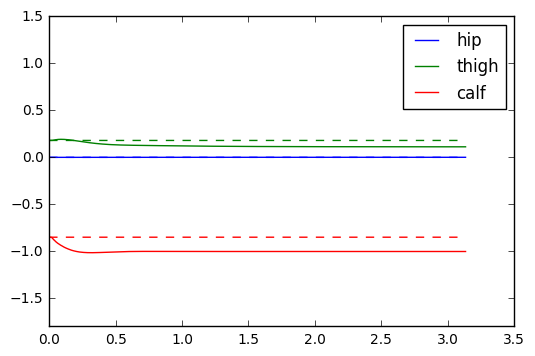

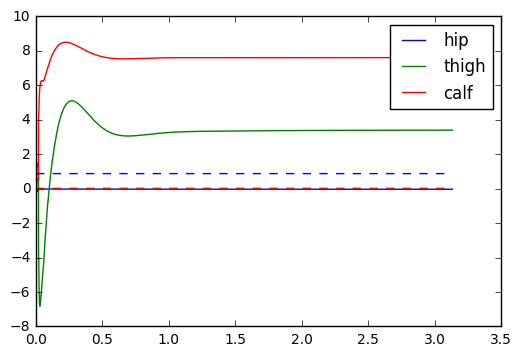

In [32]:
from matplotlib.pylab import plt
t = np.linspace(0, log_data.shape[1]*timestep, num =log_data.shape[1])

leg_no = 1

q_h_d = np.ones(log_data.shape[1]) * init_state[0 + leg_no - 1]
q_t_d = np.ones(log_data.shape[1]) * init_state[4 + leg_no - 1]
q_c_d = np.ones(log_data.shape[1]) * init_state[8 + leg_no - 1]

q_h = log_data[7 + leg_no - 1]
q_t = log_data[11 + leg_no - 1]
q_c = log_data[15 + leg_no - 1]


c_h = command_data[3*(leg_no - 1)]
c_t = command_data[3*(leg_no - 1) + 1]
c_c = command_data[3*(leg_no - 1) +2]

c_h_ff = ff_command_data[3*(leg_no - 1)]
c_t_ff = ff_command_data[3*(leg_no - 1) + 1]
c_c_ff = ff_command_data[3*(leg_no - 1) +2]


plt.figure()
plt.plot(t, q_h, 'b',  label = 'hip')
plt.plot(t, q_t, 'g',  label = 'thigh')
plt.plot(t, q_c, 'r',  label = 'calf')
plt.legend()

plt.plot(t, q_h_d, '--b',  label = 'hip')
plt.plot(t, q_t_d, '--g',  label = 'thigh')
plt.plot(t, q_c_d, '--r',  label = 'calf')

plt.ylim([-1.8, 1.5])

plt.figure()
plt.plot(t, c_h, 'b',  label = 'hip')
plt.plot(t, c_t, 'g',  label = 'thigh')
plt.plot(t, c_c, 'r',  label = 'calf')
plt.legend()

plt.plot(t, c_h_ff, '--b',  label = 'hip')
plt.plot(t, c_t_ff, '--g',  label = 'thigh')
plt.plot(t, c_c_ff, '--r',  label = 'calf')


# for i in range(12):
#     plt.figure()
#     plt.plot(t, log_data[i], label = str(i))
#     plt.legend()
plt.show()

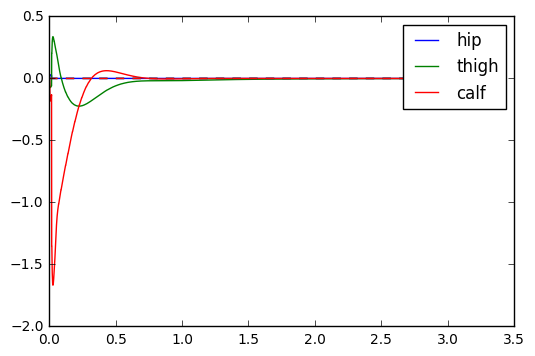

In [33]:

qv_h_d = np.ones(log_data.shape[1]) * 0
qv_t_d = np.ones(log_data.shape[1]) * 0
qv_c_d = np.ones(log_data.shape[1]) * 0

qv_h = log_data[25 + leg_no - 1]
qv_t = log_data[29 + leg_no - 1]
qv_c = log_data[33 + leg_no - 1]


 


plt.figure()
plt.plot(t, qv_h, 'b',  label = 'hip')
plt.plot(t, qv_t, 'g',  label = 'thigh')
plt.plot(t, qv_c, 'r',  label = 'calf')
plt.legend()

plt.plot(t, qv_h_d, '--b',  label = 'hip')
plt.plot(t, qv_t_d, '--g',  label = 'thigh')
plt.plot(t, qv_c_d, '--r',  label = 'calf')

#plt.ylim([-1.8, 1.5])
 


# for i in range(12):
#     plt.figure()
#     plt.plot(t, log_data[i], label = str(i))
#     plt.legend()
plt.show()

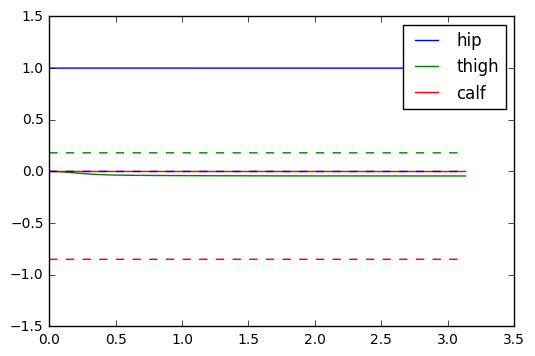

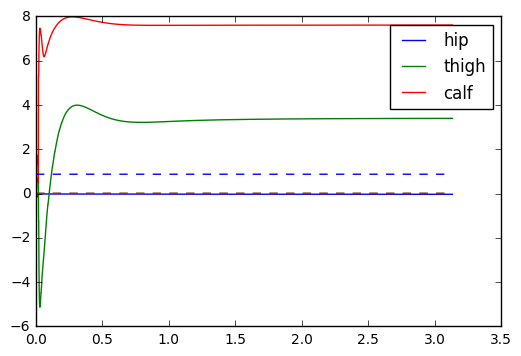

In [8]:
from matplotlib.pylab import plt
t = np.linspace(0, log_data.shape[1]*timestep, num =log_data.shape[1])

leg_no = 1

q_h_d = np.ones(log_data.shape[1]) * init_state[0 + leg_no - 1]
q_t_d = np.ones(log_data.shape[1]) * init_state[4 + leg_no - 1]
q_c_d = np.ones(log_data.shape[1]) * init_state[8 + leg_no - 1]

q_h = log_data[0 + leg_no - 1]
q_t = log_data[4 + leg_no - 1]
q_c = log_data[8 + leg_no - 1]


c_h = command_data[3*(leg_no - 1)]
c_t = command_data[3*(leg_no - 1) + 1]
c_c = command_data[3*(leg_no - 1) +2]

c_h_ff = ff_command_data[3*(leg_no - 1)]
c_t_ff = ff_command_data[3*(leg_no - 1) + 1]
c_c_ff = ff_command_data[3*(leg_no - 1) +2]


plt.figure()
plt.plot(t, q_h, 'b',  label = 'hip')
plt.plot(t, q_t, 'g',  label = 'thigh')
plt.plot(t, q_c, 'r',  label = 'calf')
plt.legend()

plt.plot(t, q_h_d, '--b',  label = 'hip')
plt.plot(t, q_t_d, '--g',  label = 'thigh')
plt.plot(t, q_c_d, '--r',  label = 'calf')

plt.ylim([-1.5, 1.5])

plt.figure()
plt.plot(t, c_h, 'b',  label = 'hip')
plt.plot(t, c_t, 'g',  label = 'thigh')
plt.plot(t, c_c, 'r',  label = 'calf')
plt.legend()

plt.plot(t, c_h_ff, '--b',  label = 'hip')
plt.plot(t, c_t_ff, '--g',  label = 'thigh')
plt.plot(t, c_c_ff, '--r',  label = 'calf')


# for i in range(12):
#     plt.figure()
#     plt.plot(t, log_data[i], label = str(i))
#     plt.legend()
plt.show()

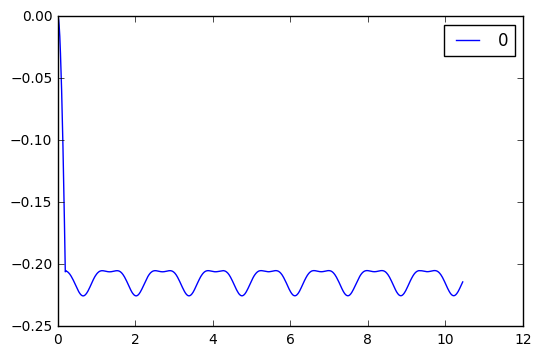

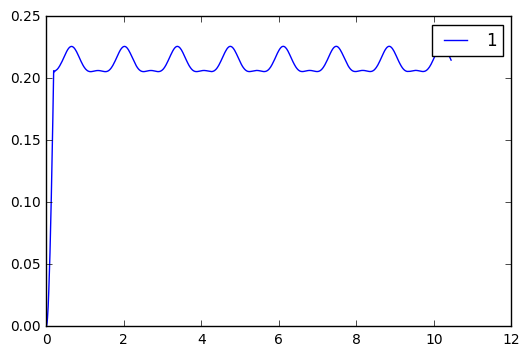

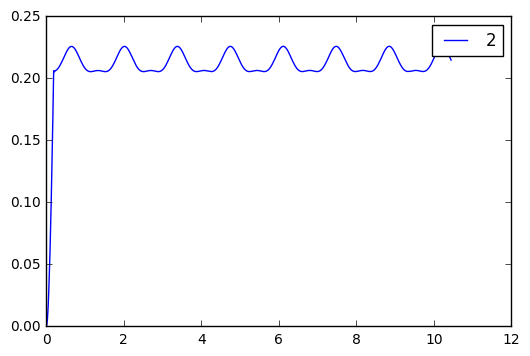

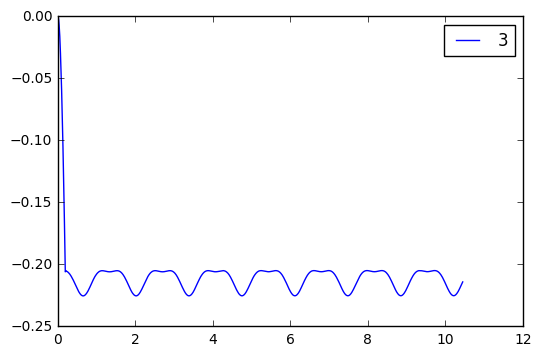

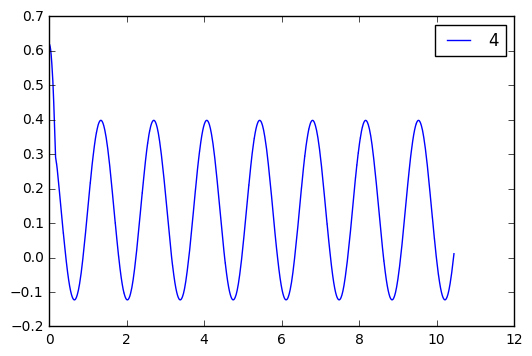

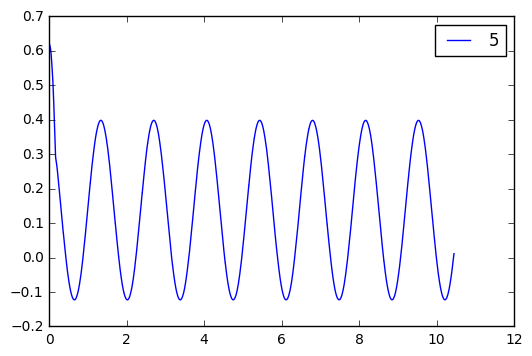

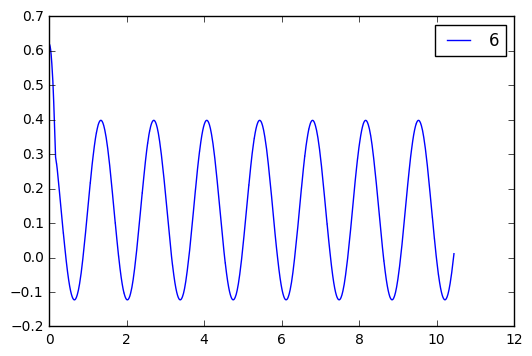

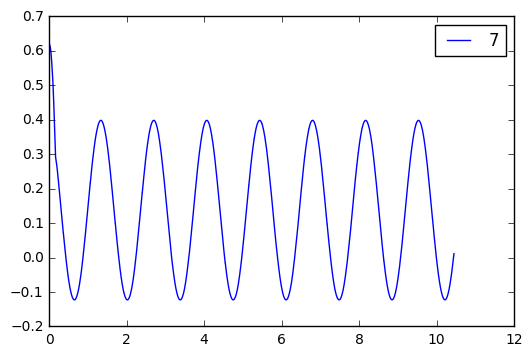

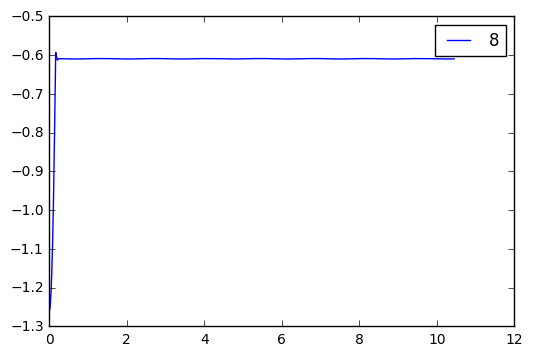

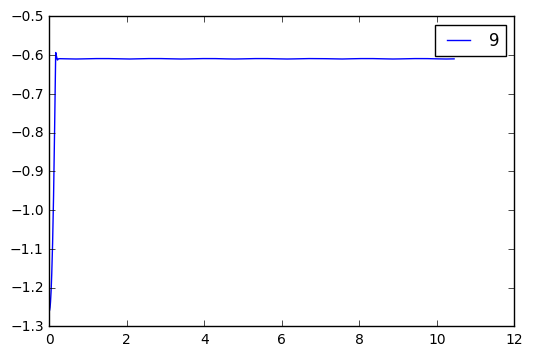

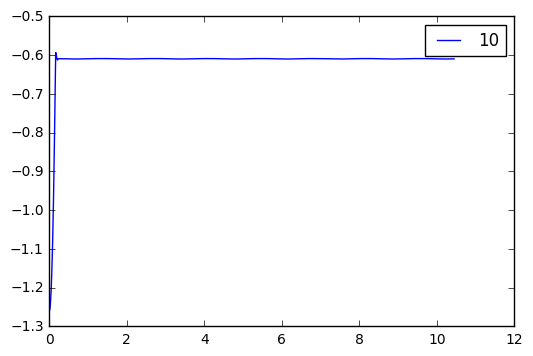

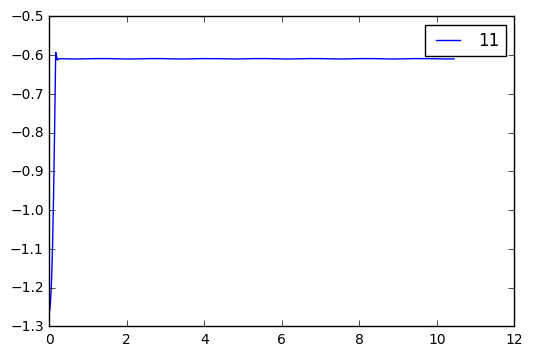

In [13]:
from matplotlib.pylab import plt
t = np.linspace(0, log_data.shape[1]*timestep, num =log_data.shape[1])


for i in range(12):
    plt.figure()
    plt.plot(t, log_data[i], label = str(i))
    plt.legend()
plt.show()

In [679]:
fl_j = mbp.GetJointByName('FL_hip_joint')
fl_j.velocity_start()

6

In [676]:
motor_name = [
"FL_hip_joint", "FR_hip_joint", "RR_hip_joint", "RL_hip_joint",
"FL_thigh_joint", "FR_thigh_joint", "RR_thigh_joint", "RL_thigh_joint",
"FL_calf_joint", "FR_calf_joint", "RR_calf_joint", "RL_calf_joint",
]

actuator_name = [
'FL_hip_motor', 'FL_thigh_motor', 'FL_calf_motor',
'FR_hip_motor', 'FR_thigh_motor', 'FR_calf_motor',
'RR_hip_motor', 'RR_thigh_motor', 'RR_calf_motor',
'RL_hip_motor', 'RL_thigh_motor', 'RL_calf_motor']

In [680]:
for i in range(12):
    print(motor_name[i])
    print(mbp.GetJointByName(motor_name[i]).position_start())
    print(mbp.GetJointByName(motor_name[i]).velocity_start())

FL_hip_joint
7
6
FR_hip_joint
8
7
RR_hip_joint
9
8
RL_hip_joint
10
9
FL_thigh_joint
11
10
FR_thigh_joint
12
11
RR_thigh_joint
13
12
RL_thigh_joint
14
13
FL_calf_joint
15
14
FR_calf_joint
16
15
RR_calf_joint
17
16
RL_calf_joint
18
17


In [687]:
a = np.arange(19)
b = np.ones(18)*1.2

c = np.concatenate((a, b))
print(c)

[  0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
  12.   13.   14.   15.   16.   17.   18.    1.2   1.2   1.2   1.2   1.2
   1.2   1.2   1.2   1.2   1.2   1.2   1.2   1.2   1.2   1.2   1.2   1.2
   1.2]


In [691]:
c

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [690]:
c = np.arange(37)
d = c[25:37]
d.shape

(12,)

In [682]:

mbp.num_positions(laikago_model)

19

In [683]:
mbp.num_velocities(laikago_model)

18

In [685]:
mbp.num_multibody_states()

37

In [684]:
mbp.num_model_instances()

5

In [183]:
actuator_choice_matrix.T

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [ ]:
u = np.array()

In [184]:
# original
#actuator_choice_matrix
# array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
#        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
#        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [5]:
for i in range(12):
    print(i)
    print(rbt.get_position_name(i))

0
FL_hip_joint
1
FL_thigh_joint
2
FL_calf_joint
3
FR_hip_joint
4
FR_thigh_joint
5
FR_calf_joint
6
RR_hip_joint
7
RR_thigh_joint
8
RR_calf_joint
9
RL_hip_joint
10
RL_thigh_joint
11
RL_calf_joint


In [6]:
mbp.get_output_port()

<pydrake.systems.framework.OutputPort_[float] at 0x7f860c03b1f0>

In [14]:
mbp.GetJointActuatorByName('RR_hip_motor')



In [13]:
mbp.GetPositionUpperLimits()

array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,  1.04719755,  0.87266463,  0.87266463,
        1.04719755,  3.92699082,  3.92699082,  3.92699082,  3.92699082,
       -0.61086524, -0.61086524, -0.61086524, -0.61086524])

In [19]:
mbp.MakeActuationMatrix().shape

(18, 12)

In [18]:
mbp.num_actuated_dofs()

12